# **UC3. How many subscribers will be on-line in my network next week?**

For several reasons, we need to predict what the network will look like at a certain point in the future. We want to forecast traffic accurately to plan capacity provisioning in advance, forecast subscribers to plan for IP address pool capacity, and forecast user demand to plan for our K8s cluster capacity. Failure to do so could result in service unavailability, missed SLAs, and potential customer churn.

So, how can we make reasonable predictions for a specific metric to take action now based on future forecasts? This is the main issue we aim to solve. In this case, we want to properly plan the capacity of IP address pools for our BNGs by estimating the number of subscribers expected over the coming days at different hours. If successful, this will provide a solid basis for determining the necessary size of the IP pools and provisioning them accordingly.

# Connection to drive and path definition (Just for Google Colab Lab)




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
path_files ='/content/drive/MyDrive/Colab Notebooks/Files'

# ***OR***
# Connection path definition (Just for AWS Jupiter Notebook)

In [ ]:
import sys
path_files ='./Files'

# Import libraries

In [1]:
pip install statsmodels

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from os import listdir
from os.path import isfile, join

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
from scipy.stats import iqr

# Data Collection

We will load a data set that contains number of subscribers for PE-5 for a period of 29 days, with 5 minute frequency

In [5]:
metric_df=pd.read_csv(join(path_files,'bng_subscribers_metric_forecast.csv'),index_col=0)

In [6]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address
0,1759276801,3187.687938,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
1,1759277101,2943.003328,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
2,1759277401,2766.260865,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
3,1759277701,3240.283369,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
4,1759278001,3205.252326,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
...,...,...,...,...,...,...,...,...,...,...
8347,1761780901,7072.825641,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
8348,1761781201,7922.322242,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
8349,1761781501,6010.169864,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
8350,1761781801,5824.291268,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5


# Data preparation

In [7]:
ds_column = []
for i,obs in metric_df.iterrows():
    #new_timestamp = datetime.fromtimestamp(obs['timestamp']).strftime('%Y-%m-%d %H:%M:%S')
    new_timestamp = datetime.fromtimestamp(obs['timestamp'])
    ds_column.append(new_timestamp)
metric_df['ds']=ds_column
metric_df['y']=metric_df['bng_subscribers']



In [8]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address,ds,y
0,1759276801,3187.687938,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-01 00:00:01,3187.687938
1,1759277101,2943.003328,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-01 00:05:01,2943.003328
2,1759277401,2766.260865,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-01 00:10:01,2766.260865
3,1759277701,3240.283369,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-01 00:15:01,3240.283369
4,1759278001,3205.252326,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-01 00:20:01,3205.252326
...,...,...,...,...,...,...,...,...,...,...,...,...
8347,1761780901,7072.825641,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-29 23:35:01,7072.825641
8348,1761781201,7922.322242,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-29 23:40:01,7922.322242
8349,1761781501,6010.169864,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-29 23:45:01,6010.169864
8350,1761781801,5824.291268,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-29 23:50:01,5824.291268


Text(0.5, 1.0, 'BNG Subscribers')

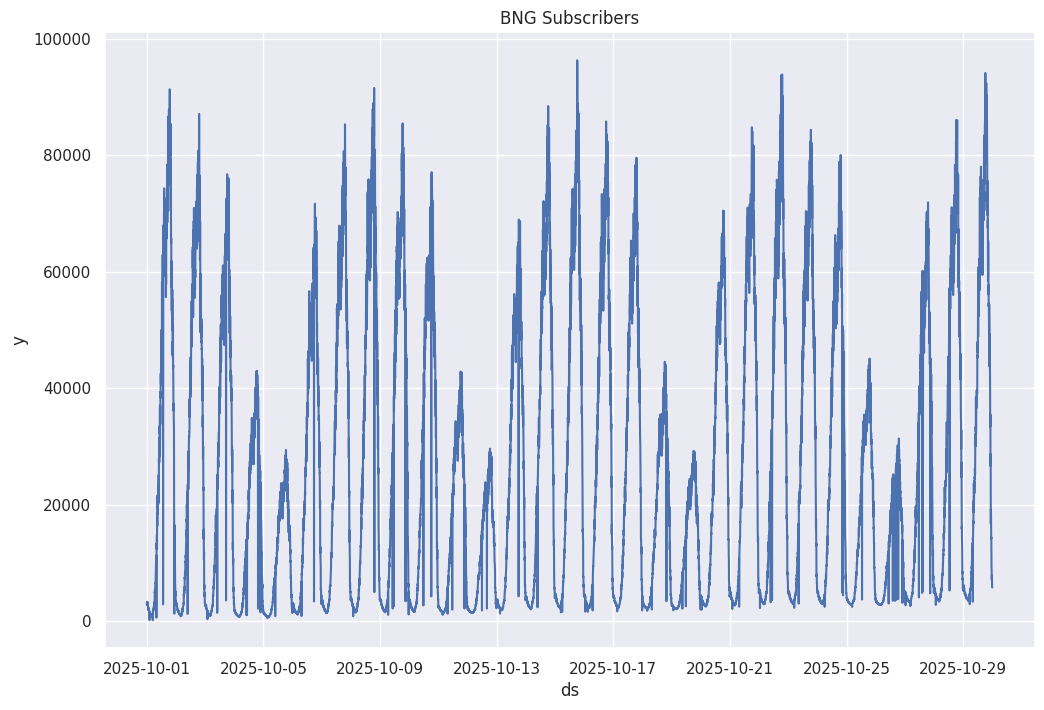

In [9]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'], y=metric_df['y'])
plt.title('BNG Subscribers')

In [10]:
df = metric_df[['ds','y']].set_index('ds')


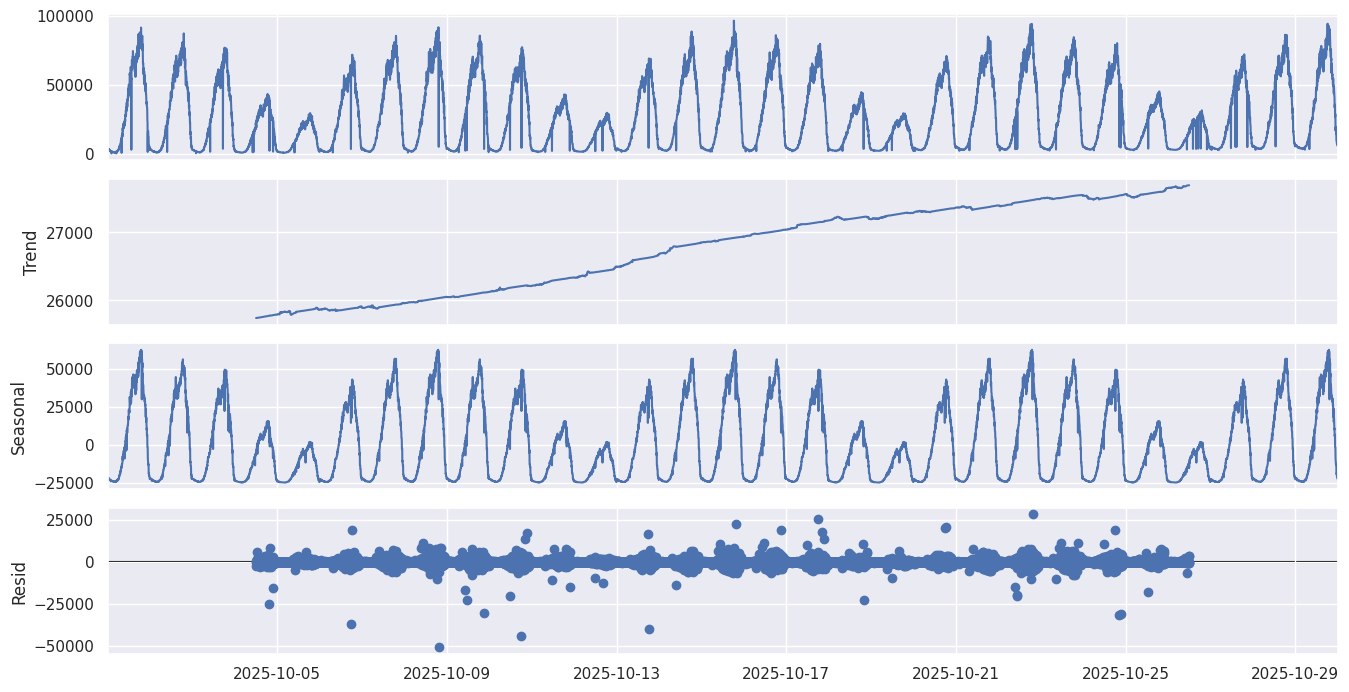

(ds
 2025-10-01 00:00:01   NaN
 2025-10-01 00:05:01   NaN
 2025-10-01 00:10:01   NaN
 2025-10-01 00:15:01   NaN
 2025-10-01 00:20:01   NaN
                        ..
 2025-10-29 23:35:01   NaN
 2025-10-29 23:40:01   NaN
 2025-10-29 23:45:01   NaN
 2025-10-29 23:50:01   NaN
 2025-10-29 23:55:01   NaN
 Name: trend, Length: 8352, dtype: float64,
 ds
 2025-10-01 00:00:01   -22398.282628
 2025-10-01 00:05:01   -22123.636844
 2025-10-01 00:10:01   -22138.299702
 2025-10-01 00:15:01   -22278.795370
 2025-10-01 00:20:01   -22101.463742
                            ...     
 2025-10-29 23:35:01   -20630.147887
 2025-10-29 23:40:01   -20800.766276
 2025-10-29 23:45:01   -22321.443355
 2025-10-29 23:50:01   -22456.408763
 2025-10-29 23:55:01   -22358.739441
 Name: seasonal, Length: 8352, dtype: float64,
 ds
 2025-10-01 00:00:01   NaN
 2025-10-01 00:05:01   NaN
 2025-10-01 00:10:01   NaN
 2025-10-01 00:15:01   NaN
 2025-10-01 00:20:01   NaN
                        ..
 2025-10-29 23:35:01   NaN
 202

In [11]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive',period=2016)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()

    return trend, seasonal, residual

seasonal_decompose(df)

In statsmodels, when you use *decomposition.resid*, it gives you the residual component of the time series after removing the trend and seasonality. The residual represents the part of the data that cannot be explained by the trend and seasonality, and it typically includes noise or random fluctuations.

# Naive model

We want to forecast 1 day, which means 288 observations.

**Approach 1:** The "naïve approach" in time series forecasting is a simple method where the forecast for the next time point is assumed to be exactly the same as the previous observed value.
In other words, for each new time period, the model predicts that the value will remain unchanged from the last observed value. This approach works under the assumption that there is no significant trend, seasonality, or pattern influencing future values. It is often used as a baseline model to compare the performance of more sophisticated forecasting methods.


To do this, We will use the data from an entire seasonal period, which is one week (2016 observations) >>>

naive prediction: y_pred = y[t-2016]

In [12]:
y_pred_naive = df['y'][:-2016].values.reshape(-1,1)

In [13]:
y_pred_naive.shape

(6336, 1)

In [14]:
df.loc[df.index[2016:],'y_pred_naive']=y_pred_naive

In [15]:
df

,y,y_pred_naive
ds,,
2025-10-01 00:00:01,3187.687938,NaN
2025-10-01 00:05:01,2943.003328,NaN
2025-10-01 00:10:01,2766.260865,NaN
2025-10-01 00:15:01,3240.283369,NaN
2025-10-01 00:20:01,3205.252326,NaN
...,...,...
2025-10-29 23:35:01,7072.825641,7126.702792
2025-10-29 23:40:01,7922.322242,6970.797848
2025-10-29 23:45:01,6010.169864,5372.021854


We can estimate how well the model is performing by comparing the predicted value with the actual value of the metric at each point in time. We will use two metrics: **Mean Absolute Error** (MAE), which estimates the error based on the absolute difference. However, absolute error may not always be suitable as it does not provide a relative perspective based on the actual values. Alternatively, we have **Mean Absolute Percentage Error** (MAPE), which normalizes the error relative to the actual values, offering a better sense of the degree or proportion of deviations.

In [16]:
performance_naive_MAE = mean_absolute_error(df['y'][2016:], df['y_pred_naive'][2016:])
print(f'The MAE for the model is {performance_naive_MAE}')

performance_naive_MAPE = mean_absolute_percentage_error(df['y'][2016:], df['y_pred_naive'][2016:])
print(f'The MAPE for the model is {performance_naive_MAPE}')

The MAE for the model is 2203.32167765534
The MAPE for the model is 0.1690687782118035


<Axes: xlabel='ds', ylabel='y'>

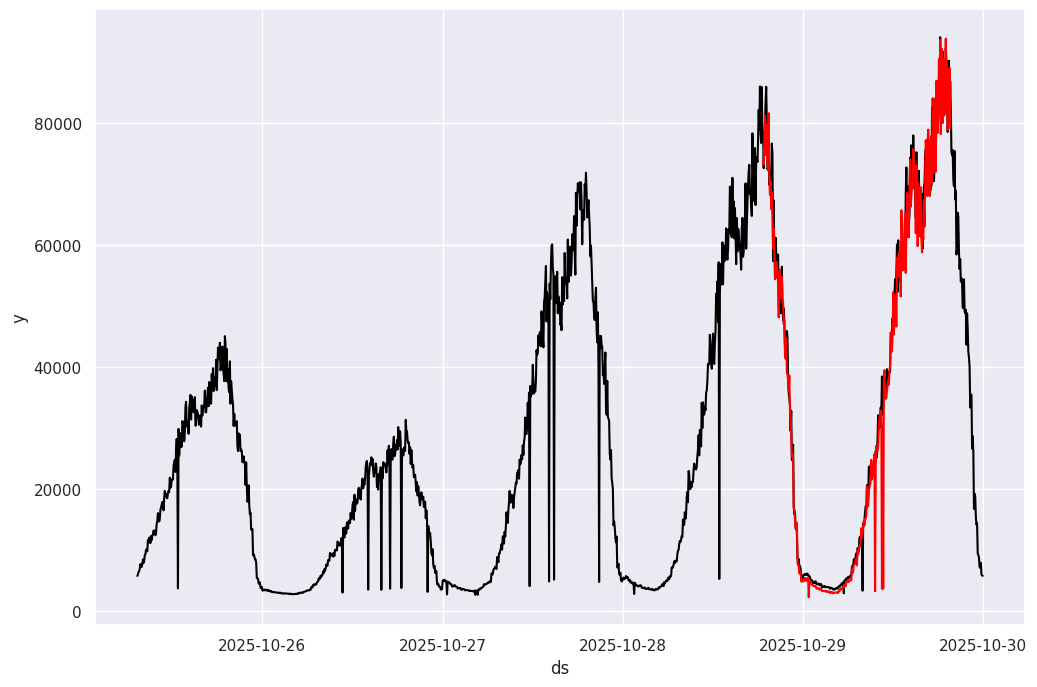

In [17]:
sns.lineplot(x=df.index[7000:], y='y', data=df[7000:], color='black')
sns.lineplot(x=df.index[8000:8300], y='y_pred_naive', data=df[8000:8300], color='red')

# Holt Winters

**Approach 2:** The **Holt-Winters** technique, also known as **triple exponential smoothing**, is a forecasting method used for time series data that includes three main components:

1. **Level (L)**: The estimate of the average or baseline value of the time series.
2. **Trend (T)**: The rate of change or direction in which the time series is moving (upward or downward).
3. **Seasonality (S)**: The repeating fluctuations occurring at regular intervals, such as daily, monthly, or yearly patterns.

This model adjusts these three components over time, allowing for more accurate forecasts, especially in time series with seasonality and trends.

The Holt-Winters model has two main versions:
- **Additive**: Used when the magnitude of seasonality is constant over time.
- **Multiplicative**: Used when the magnitude of seasonality changes in proportion to the trend.

The general Holt-Winters formula involves three equations that update the level, trend, and seasonality at each time step, adjusting the forecasts according to these components.

In [18]:
def holtwin(y_to_train, seasonal_period, predict_date):

    holt = ExponentialSmoothing(y_to_train, seasonal_periods=seasonal_period, trend='add', seasonal='add',use_boxcox=True).fit()
    y_forecast = holt.forecast(predict_date).rename('Additive')
    return y_forecast


We used the observations up to position 8000 to train the model and requested a prediction for the next 300 observations (just over one day). We also informed the model of the identified seasonality, which in this case is seven days (2016 observations).

**Warning: Next task will last around 5 minutes**

In [19]:
y_holtwin_pred = holtwin(df['y'][:8000],2016,300)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


In [21]:
performance_holtwint_MAE = mean_absolute_error(df['y'][8000:8300], y_holtwin_pred)
print(f'The MAE for the model is {performance_holtwint_MAE}')
performance_holtwint_MAPE = mean_absolute_percentage_error(df['y'][8000:8300], y_holtwin_pred)
print(f'The MAPE for the model is {performance_holtwint_MAPE}')

The MAE for the model is 2799.3439410549727
The MAPE for the model is 0.14341830572241235


<Axes: xlabel='ds', ylabel='y'>

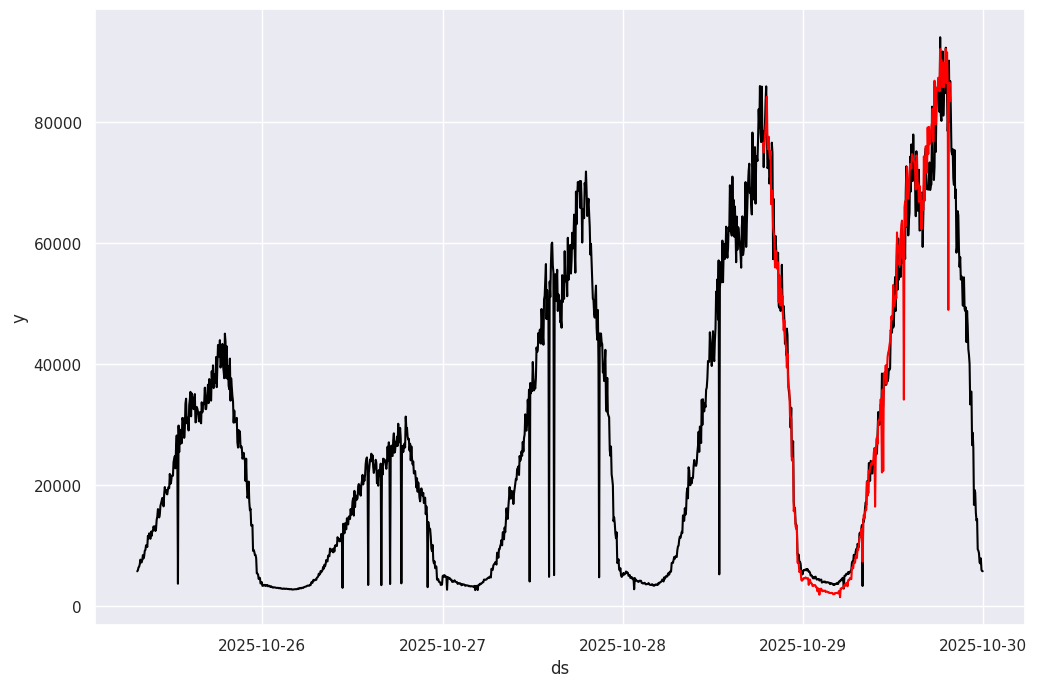

In [22]:
sns.lineplot(x=df.index[7000:], y='y', data=df[7000:], color='black')
sns.lineplot(x=df.index[8000:8300], y=y_holtwin_pred, color='red')

We can still observe a quite noisy prediction, likely due to the fact that the anomalies are causing the model to produce this variability in the forecast as well.